* Importação das bibliotecas necessárias:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")


# 1. Coletando e tratando os dados:

In [2]:
# Coletando dados da VALE3 e formatando o DataFrame:
vale = yf.download('VALE3.SA', start='2022-01-01', end='2025-06-01', multi_level_index=False)
vale = vale[['Close', 'Open', 'Volume']]
vale.reset_index(inplace=True)
vale['Date'] = pd.to_datetime(vale['Date'])
vale.set_index('Date', inplace=True)

# Criando um DataFrame para armazenar os dados do minério de ferro:
minerio_ferro = pd.read_csv(
    "Dados Históricos - Minério de ferro refinado 62% Fe CFR Futuros.csv"
    )
minerio_ferro.reset_index(inplace=True)
minerio_ferro['Data'] = pd.to_datetime(minerio_ferro['Data'], dayfirst=True)
minerio_ferro.set_index('Data', inplace=True)
minerio_ferro = minerio_ferro[['Último','Abertura', 'Var%']]
# invertendo a ordem das datas:
minerio_ferro = minerio_ferro.iloc[::-1]
minerio_ferro.rename(columns={
    'Último': 'Close',
    'Abertura': 'Open',
    'Var%': 'Variação'
}, inplace=True)

# Unindo os DataFrames de VALE3 e minério de ferro:
df = pd.merge(vale, minerio_ferro, left_index=True, right_index=True, suffixes=('_VALE3', '_Minerio'))
df.rename(columns={
    'Close_VALE3': 'Close_VALE3',
    'Open_VALE3': 'Open_VALE3',
    'Volume': 'Volume_VALE3',
    'Close_Minerio': 'Close_Minerio',
    'Open_Minerio': 'Open_Minerio',
    'Variação': 'Variação_Minerio'
}, inplace=True)

# Variação percentual do preço de fechamento da VALE3:
df['Variação_VALE3'] = df['Close_VALE3'].pct_change() * 100
# Trocando nan por 0%:
df['Variação_VALE3'].fillna(0, inplace=True)

# Vamos transformar as colunas Close_Minerio, Open_Minerio e Variação_Minerio em float:
df['Close_Minerio'] = df['Close_Minerio'].str.replace(',', '.', regex=False).astype(float)
df['Open_Minerio'] = df['Open_Minerio'].str.replace(',', '.', regex=False).astype(float)
df['Variação_Minerio'] = df['Variação_Minerio'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Variação percentual do preço de fechamento do minério de ferro:
df['Variação_Minerio'] = df['Close_Minerio'].pct_change() * 100 
# Trocando nan por 7,02%:
df['Variação_Minerio'].fillna(7.02, inplace=True)

df

[*********************100%***********************]  1 of 1 completed


,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3
2022-01-03,57.766403,58.506998,18557200,120.40,120.40,7.020000,0.000000
2022-01-04,57.085075,58.144127,18178700,120.91,120.91,0.423588,-1.179453
2022-01-05,57.625694,57.299836,22039000,124.14,124.14,2.671408,0.947041
2022-01-06,58.788429,58.240391,22044100,125.94,125.94,1.449976,2.017737
2022-01-07,62.209991,59.543850,35213100,126.21,126.21,0.214388,5.820129
...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894


# 2. Fetures temporais.

In [3]:
# Vamos adicionar as fetures de dias, semanas, meses, anos e calcular o seno e o cosseno do mês para capturar sazonalidade cíclica:
df['Dia'] = df.index.day
df['Semana'] = df.index.weekday
df['Mês'] = df.index.month
df['Ano'] = df.index.year

df['Sin_Mês'] = np.sin(2 * np.pi * df['Mês'] / 12)
df['Cos_Mês'] = np.cos(2 * np.pi * df['Mês'] / 12)

# Vamos adicionar médias móveis de 20 e 200 dias no preço de fechamento da VALE3 e do minério de ferro:
df['MM_20D_VALE3'] = df['Close_VALE3'].rolling(window=20, min_periods=1).mean()
df['MM_200D_VALE3'] = df['Close_VALE3'].rolling(window=200, min_periods=1).mean()
df['MM_20D_MF'] = df['Close_Minerio'].rolling(window=20, min_periods=1).mean()
df['MM_200D_MF'] = df['Close_Minerio'].rolling(window=200, min_periods=1).mean()

# Coluna do preço anterior(D-1):
df['Close_VALE3_D-1'] = df['Close_VALE3'].shift(1)
df['Close_VALE3_D-1'].fillna(0, inplace=True)

df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,Ano,Sin_Mês,Cos_Mês,MM_20D_VALE3,MM_200D_VALE3,MM_20D_MF,MM_200D_MF,Close_VALE3_D-1
2022-01-03,57.766403,58.506998,18557200,120.40,120.40,7.020000,0.000000,3,0,1,2022,0.5,0.866025,57.766403,57.766403,120.400000,120.400000,0.000000
2022-01-04,57.085075,58.144127,18178700,120.91,120.91,0.423588,-1.179453,4,1,1,2022,0.5,0.866025,57.425739,57.425739,120.655000,120.655000,57.766403
2022-01-05,57.625694,57.299836,22039000,124.14,124.14,2.671408,0.947041,5,2,1,2022,0.5,0.866025,57.492391,57.492391,121.816667,121.816667,57.085075
2022-01-06,58.788429,58.240391,22044100,125.94,125.94,1.449976,2.017737,6,3,1,2022,0.5,0.866025,57.816401,57.816401,122.847500,122.847500,57.625694
2022-01-07,62.209991,59.543850,35213100,126.21,126.21,0.214388,5.820129,7,4,1,2022,0.5,0.866025,58.695119,58.695119,123.520000,123.520000,58.788429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,2025,0.5,-0.866025,54.055500,54.977746,99.505000,101.648300,54.230000
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,2025,0.5,-0.866025,54.055000,54.964091,99.483000,101.611400,54.320000
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,2025,0.5,-0.866025,54.023500,54.947779,99.457000,101.575400,53.840000
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,2025,0.5,-0.866025,54.004000,54.937926,99.427500,101.540500,53.410000


* Visualizando series temporais:

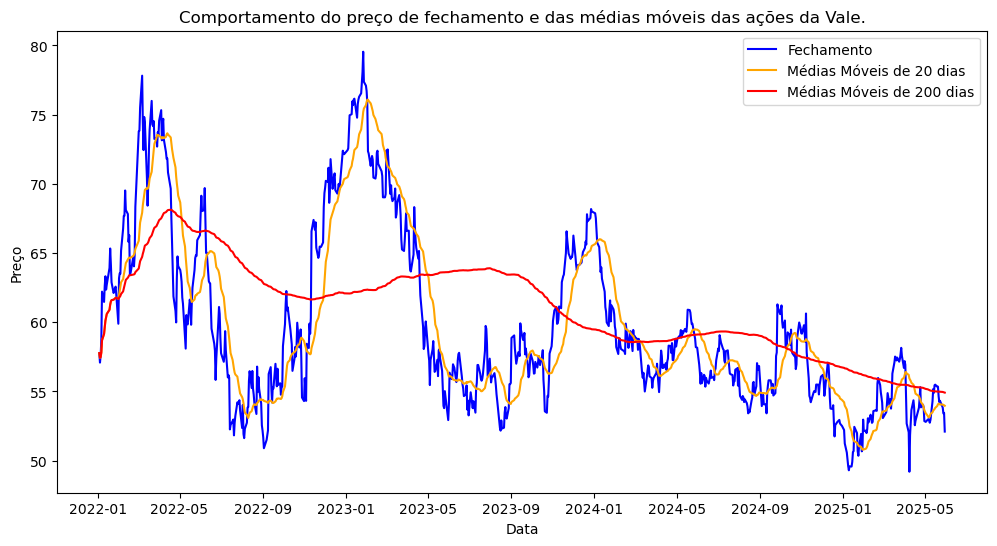

In [4]:
# Vamos visualizar o comportamento de fechamento e médias móveis das ações da VALE:

plt.figure(figsize=(12,6))
plt.plot(df['Close_VALE3'], label='Fechamento', color='blue')
plt.plot(df['MM_20D_VALE3'], label='Médias Móveis de 20 dias', color='orange')
plt.plot(df['MM_200D_VALE3'], label='Médias Móveis de 200 dias', color='red')
plt.title('Comportamento do preço de fechamento e das médias móveis das ações da Vale.')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

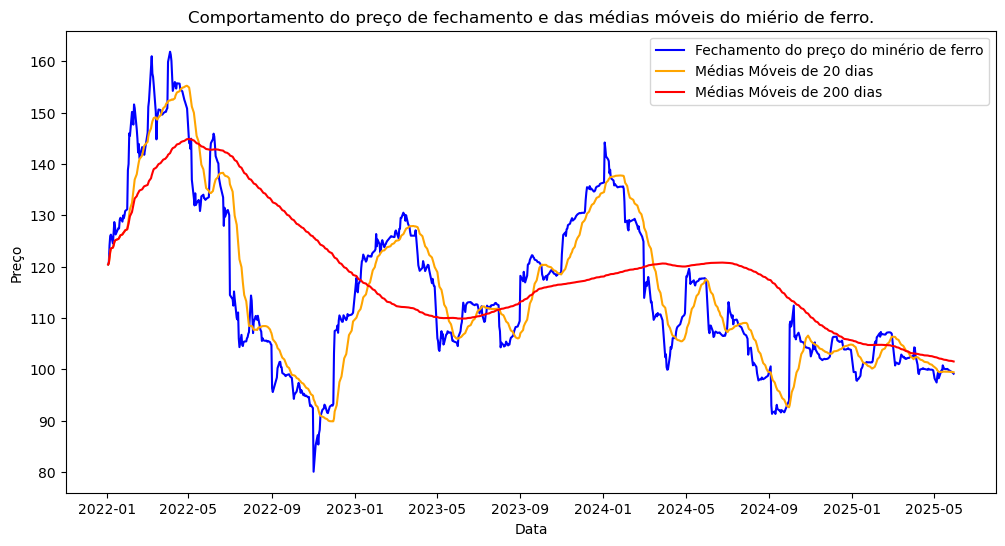

In [5]:
# Vamos visualizar o comportamento de abertura, fechamento e médias móveis das ações do minério de ferro:

plt.figure(figsize=(12,6))
plt.plot(df['Close_Minerio'], label='Fechamento do preço do minério de ferro', color='blue')
plt.plot(df['MM_20D_MF'], label='Médias Móveis de 20 dias', color='orange')
plt.plot(df['MM_200D_MF'], label='Médias Móveis de 200 dias', color='red')
plt.title('Comportamento do preço de fechamento e das médias móveis do miério de ferro.')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

# 3. Decomposição da Serie Temporal.

In [6]:
decomposicao = seasonal_decompose(df['Close_VALE3'], model='multiplicative', period=30)
df['Tendencia'] = decomposicao.trend
df['Sazonalidade'] = decomposicao.seasonal
df['Residuo'] = decomposicao.resid

# Preencher valores ausentes resultantes da decomposição:
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

# 4. Lags e Rolling Statistics.

* Vamos criar colunas que trazem o preço de fechamento e o retorno percentual de ontem, anteontem, etc. Assim o modelo “vê” vários dias anteriores:

In [7]:
lags = [1, 2, 3, 4, 5] # dias de atraso

for lag in lags:
    df[f'Close_Vale_lag{lag}'] = df['Close_VALE3'].shift(lag) # Preço do fechamento lagado
    df[f'Ret_Vale_lag{lag}'] = df['Close_VALE3'].shift(lag) # Retorno percentual lagado

* Agora, para captar tendências e volatilidade de curto e médio prazo, vamos criar médias móveis de curto prazo e estatísticas móveis (desvio, assimetria, curtose) em janelas de vários tamanhos:

In [8]:
windows = [5, 10, 15, 30, 50] # Janelas de dias

for w in windows:
    # Média móvel
    df[f'MM_de_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).mean()
    # Desvio-padrão móvel dos retornos em w dias
    df[f'Desvio_Padrao_de_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).std()
    # Assimetria móvel dos retornos
    df[f'roll_skew_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).skew()
    # Curtose móvel dos retornos
    df[f'Curtose_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).kurt()
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,...,roll_skew_15,Curtose_15,MM_de_30,Desvio_Padrao_de_30,roll_skew_30,Curtose_30,MM_de_50,Desvio_Padrao_de_50,roll_skew_50,Curtose_50
2022-01-03,57.766403,58.506998,18557200,120.40,120.40,7.020000,0.000000,3,0,1,...,NaN,NaN,57.766403,NaN,NaN,NaN,57.766403,NaN,NaN,NaN
2022-01-04,57.085075,58.144127,18178700,120.91,120.91,0.423588,-1.179453,4,1,1,...,NaN,NaN,57.425739,0.481772,NaN,NaN,57.425739,0.481772,NaN,NaN
2022-01-05,57.625694,57.299836,22039000,124.14,124.14,2.671408,0.947041,5,2,1,...,-1.438658,NaN,57.492391,0.359693,-1.438658,NaN,57.492391,0.359693,-1.438658,NaN
2022-01-06,58.788429,58.240391,22044100,125.94,125.94,1.449976,2.017737,6,3,1,...,0.963006,1.852718,57.816401,0.711464,0.963006,1.852718,57.816401,0.711464,0.963006,1.852718
2022-01-07,62.209991,59.543850,35213100,126.21,126.21,0.214388,5.820129,7,4,1,...,1.776405,3.220451,58.695119,2.059215,1.776405,3.220451,58.695119,2.059215,1.776405,3.220451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,...,-0.324580,-1.637176,53.886667,1.031050,0.026033,-1.077892,54.707800,1.957700,-0.092500,-0.233223
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,...,-0.414413,-1.341707,53.953000,0.956845,0.165655,-1.250139,54.709400,1.956942,-0.094601,-0.228681
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,...,-0.421093,-1.216086,53.974000,0.936919,0.169704,-1.187451,54.687600,1.965375,-0.064842,-0.278782
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,...,-0.394918,-1.104977,53.967000,0.940125,0.186887,-1.207078,54.630800,1.959149,0.008174,-0.252883


In [9]:
df = df.dropna()
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,...,roll_skew_15,Curtose_15,MM_de_30,Desvio_Padrao_de_30,roll_skew_30,Curtose_30,MM_de_50,Desvio_Padrao_de_50,roll_skew_50,Curtose_50
2022-01-10,61.469383,61.091678,25056700,124.48,124.48,-1.370731,-1.190497,10,0,1,...,0.758629,-1.666754,59.157496,2.162186,0.758629,-1.666754,59.157496,2.162186,0.758629,-1.666754
2022-01-11,62.639530,61.824877,28418800,126.75,126.75,1.823586,1.903626,11,1,1,...,0.288823,-2.355138,59.654930,2.372331,0.288823,-2.355138,59.654930,2.372331,0.288823,-2.355138
2022-01-12,63.320877,64.054065,27335400,128.66,128.66,1.506903,1.087727,12,2,1,...,0.027982,-2.265000,60.113173,2.550266,0.027982,-2.265000,60.113173,2.550266,0.027982,-2.265000
2022-01-13,62.358109,62.832089,23154200,127.84,127.84,-0.637339,-1.520460,13,3,1,...,-0.244851,-2.134055,60.362610,2.500169,-0.244851,-2.134055,60.362610,2.500169,-0.244851,-2.134055
2022-01-14,62.720989,62.002611,21183400,126.24,126.24,-1.251564,0.581930,14,4,1,...,-0.457189,-1.914948,60.598448,2.472348,-0.457189,-1.914948,60.598448,2.472348,-0.457189,-1.914948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,...,-0.324580,-1.637176,53.886667,1.031050,0.026033,-1.077892,54.707800,1.957700,-0.092500,-0.233223
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,...,-0.414413,-1.341707,53.953000,0.956845,0.165655,-1.250139,54.709400,1.956942,-0.094601,-0.228681
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,...,-0.421093,-1.216086,53.974000,0.936919,0.169704,-1.187451,54.687600,1.965375,-0.064842,-0.278782
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,...,-0.394918,-1.104977,53.967000,0.940125,0.186887,-1.207078,54.630800,1.959149,0.008174,-0.252883


# 5. Indicadores Técnicos.

In [10]:
# Média móvel exponencial de 20 dias:
df['MME_20D'] = df['Close_VALE3'].ewm(span=20, adjust=False).mean()
# Média móvel exponencial de 200 dias:
df['MME_200D'] = df['Close_VALE3'].ewm(span=200, adjust=False).mean()

df[['MME_20D', 'MME_200D']]

,MME_20D,MME_200D
2022-01-10,61.469383,61.469383
2022-01-11,61.580826,61.481026
2022-01-12,61.746545,61.499333
2022-01-13,61.804789,61.507878
2022-01-14,61.892046,61.519949
...,...,...
2025-05-23,54.362165,55.085497
2025-05-27,54.312435,55.073104
2025-05-28,54.226489,55.056555
2025-05-29,54.152537,55.040570


In [ ]:
def calculo_rsi(series, window=14):
    delta = series.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI_14'] = calculo_rsi(df['Close_VALE3'], window=14)
df[['RSI_14']]

,RSI_14
2022-01-10,NaN
2022-01-11,NaN
2022-01-12,NaN
2022-01-13,NaN
2022-01-14,NaN
...,...
2025-05-23,63.709707
2025-05-27,57.777793
2025-05-28,54.450253
2025-05-29,56.327985


In [ ]:
df['RSI_14'].fillna(df['RSI_14'].mean(), inplace=True)
df[['RSI_14']]

RSI_14    0
dtype: int64

In [16]:
MME_12 = df['Close_VALE3'].ewm(span=12, adjust=False).mean()
MME_26 = df['Close_VALE3'].ewm(span=26, adjust=False).mean()

df['MACD'] = MME_12 - MME_26

df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df[['MACD', 'MACD_Signal']]

,MACD,MACD_Signal
2022-01-10,0.000000,0.000000
2022-01-11,0.093345,0.018669
2022-01-12,0.219767,0.058889
2022-01-13,0.239510,0.095013
2022-01-14,0.281196,0.132249
...,...,...
2025-05-23,0.198816,0.121362
2025-05-27,0.130217,0.123133
2025-05-28,0.040685,0.106644
2025-05-29,-0.026733,0.079968


In [21]:
# Calculando a média móvel e o desvio padrão
media_20 = df['Close_VALE3'].rolling(window=20, min_periods=1).mean()
desvio_20 = df['Close_VALE3'].rolling(window=20, min_periods=1).std()

# Calculando as bandas
df['Banda_Media'] = media_20
df['Banda_Superior'] = media_20 + (2 * desvio_20)
df['Banda_Inferior'] = media_20 - (2 * desvio_20)


df[['Banda_Media', 'Banda_Superior', 'Banda_Inferior']]

,Banda_Media,Banda_Superior,Banda_Inferior
2022-01-10,61.469383,NaN,NaN
2022-01-11,62.054457,63.709294,60.399619
2022-01-12,62.476597,64.349475,60.603719
2022-01-13,62.446975,63.980757,60.913193
2022-01-14,62.501778,63.852493,61.151062
...,...,...,...
2025-05-23,54.055500,56.080205,52.030795
2025-05-27,54.055000,56.079923,52.030077
2025-05-28,54.023500,56.068903,51.978097
2025-05-29,54.004000,56.064152,51.943848


# 6. Volatilidade e Risco.